<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/2_1_two_asset_efficient_frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.1　2資産の効率的フロンティアと最適資産構成

　現代ポートフォリオ理論を学ぶする上での、最初の一里塚が、「効率的フロンディア」の導出です。本例では、まず学習用として、2資産の株価データから、そのリスク（標準偏差）と期待リターンを算出することにより、効率的フロンティアを導出します。

In [ ]:
#[1]ライブラリ読み込み
from pandas_datareader import data
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

　ライブラリの読み込み後、データはpandas_datareaderを用いて株価データをstooqから取得します。本例では2019年1月1日から2021年12月31日までの、テンセント（700HK）と浙江吉利汽車控股（175.HK）の株価をデータフレーム（data）に格納します。

In [ ]:
#[2]株価日次データの取得
tickers=['700.HK','175.HK']#複数(2種類)の株価を同時取得
start=datetime.date(2019,1,1)#標本期間を2019年1月1日から
end=datetime.date(2021,12,31)#2021年12月31日までに指定
data=data.DataReader(tickers,'stooq',start=start,end=end).sort_values(by='Date',ascending=True)

　取得した株価日次データは、始値、終値、売買高等、複数のデータが含まれています。このため、データ前処理として、「データフレーム名.Close」により、終値のみのデータを新しいデータフレームdfに保存します。次の行では、このデータフレームdfの株価終値の前日比を「データフレーム名.pct_change()」により算出します。前日比を算出すると、必ず、データの先頭行に欠損値が生じますので、これを「データフレーム名.dropna()」により除去します。

In [ ]:
#[3]データ前処理
df=data.Close #日次データの終値のみをデータフレームdfに収納
df=df.pct_change().dropna() #データフレームdfを前期比(前日比)に変換し、欠損値を除去

　この2種類の時系列データから、株価の平均リターン（Rp）を算出します。続いて平均リターン（Rp）と同様に、分散（VAR_Rp）、共分散（Cov_Rp）を算出します。平均リターン（Rp）、分散（VAR_Rp）、共分散（Cov_Rp）は、いずれも年率換算するため×250営業日を施します。

In [ ]:
#[4]ポートフォリオ収益率の平均・分散・共分散の算出
Rp=df.mean()*250 #年率データへ換算
VAR_Rp=df.var()*250
Cov_Rp=df['700.HK'].cov(df['175.HK'])*250

　算出された平均リターン（Rp）、分散（VAR_Rp）、共分散（Cov_Rp）を用いて資産構成比率別のポートフォリオ全体のリターンとリスク（標準偏差）を算出します。ここではnumpyのnp.(arrange)を用いることで、1％ずつテンセント（吉利汽車）株の資産比率を引き上げ（低下させ）、それぞれの資産配分比率時のリターンとリスク（標準偏差）を算出します。可視化する際の横軸はリスク（標準偏差）を用いるため、ポートフォリオ全体の分散Var Rp2はnp.sqrt(Var Rp2)により標準偏差へ再計算します。

In [ ]:
#[5]資産比率別平均リターンの算出
weights=np.arange(0,1.01,0.01) #比率0%から1%刻みで100%まで増加
for i in np.arange(0,1.01,0.01):
  E_Rp=weights*Rp["700.HK"]+(1-weights)*Rp["175.HK"] #各比率ごとに平均リターンの反復計算

In [ ]:
#[6]資産比率別標準偏差の算出
for i in np.arange(0,1.01,0.01):
  Var_Rp2=weights*weights*VAR_Rp["700.HK"]+(1-weights)*(1-weights)*VAR_Rp["175.HK"]+2*weights*(1-weights)*Cov_Rp #各比率ごとに標準偏差の反復計算
Sigma_Rp=np.sqrt(Var_Rp2)

In [ ]:
#[7]可視化
plt.scatter(Sigma_Rp,E_Rp)#散布図の作成
plt.xlabel("Risk") #横軸ラベルの指定
plt.ylabel("Expected Return") #縦軸ラベルの指定

　次に、効率的フロンティアの算出に続き、資本市場線（Capital Market Line: CML）を導出します。上記までのソースコードを用いて、効率的フロンティアを描くことはできました。ところが、このままではリスクを最小化する資産の組み合わせの選択肢のうち、どの比率を選択すればよいかがわかりません。ここでは、まず、無リスク資産の金利が必要となりますので、一行目で香港ドル建て10年債利回りの金利を与えます。平均リターンと標準偏差の算出に際し、numpyを用いて算出した各資産ご比率ごとのリターンとリスクの値を、新しいpandasデータフレームdf1に格納します。これらのデータを用いてシャープレシオを算出します（s_ratio）。np.amax()を用いて、このデータから最も高いシャープレシオの抽出が可能となります（max_sr）。

In [ ]:
#[8]シャープレシオの算出
rf=0.03157 #無リスク資産の利回り(香港ドル10年債≒米ドル10年債)
columns=['Ratio']
mean_variance=pd.DataFrame(data=weights, columns=columns) #pandasデータ配列へ変換
mean_variance['Risk'] = pd.DataFrame(Sigma_Rp)
mean_variance['Expected_Returns'] = pd.DataFrame(E_Rp)
mean_variance['Sharp_Ratio'] = pd.DataFrame((E_Rp-rf)/Sigma_Rp)
s_ratio=(E_Rp-rf)/Sigma_Rp #シャープレシオの定義
max_sr=np.amax(s_ratio) #シャープレシオ最大値の変数定義
mean_variance

　続いて、すでに作成したmean_varianceのデータフレームを用いて、loc[mean_variance['Sharp_Ratio'].idxmax()]により、シャープレシオが最大となるテンセントと吉利汽車の資産構成比率、標準偏差、リターンを保存します。そして、この時の標準偏差（optimal.iloc[1,0]）、平均リターン（optimal.iloc[2,0]）の値を抽出して、それぞれを新しい変数名opt_risk、opt_returnと名付けます。

In [ ]:
#[9]最適資産比率の導出
optimal=pd.DataFrame(mean_variance.loc[mean_variance['Sharp_Ratio'].idxmax()]) #シャープレシオ最大時の比率・リスク・リターン
opt_risk=optimal.iloc[1,0] #最適資産構成時のリスク
opt_return=optimal.iloc[2,0] #最適資産構成時の期待リターン
optimal

　最後に横軸にリスク（標準偏差）、縦軸に期待リターンを採る資本市場線（CML）を効率的フロンティアとともに可視化します。資本市場線（CML）の傾きは、シャープレシオに一致します。線形の資本市場線(CML)の傾きは一定ですが、重要な点は、この資本市場線(CML)が必ず効率的フロンティアと接することになり、この接点がテンセントと吉利汽車2資産の最適資産構成となることです。

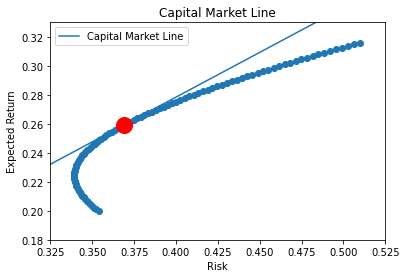

In [ ]:
#[10]資本市場線（Capital Market Line: CML）の導出
def CML(rf,sharp_R,label):#無リスク資産・シャープレシオsharp_Rの関数定義
    Risk = [x/100 for x in range(100)] #横軸Riskを設定
    ExpectedReturn = [rf+max_sr*x for x in Risk] #縦軸Epを算出
    plt.plot(Risk,ExpectedReturn,label=label)
    plt.xlabel("Risk")
    plt.xlim(0.325,0.525) #横軸の幅設定
    plt.ylabel("Expected Return")
    plt.ylim(0.18,0.33) #縦軸の幅設定
    plt.title("Capital Market Line")
    plt.plot(opt_risk,sharp_R,"ro",linestyle = "--",markersize=16) #資本市場線の作成

CML(rf,opt_return,"Capital Market Line") #CML導出
plt.scatter(Sigma_Rp,E_Rp)#効率的フロンティアの作成
plt.legend()
plt.show()